In [1]:
from PIL import Image
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# 训练集size：[5148, 256, 256] label size: [5148]
# 测试集size：[1292, 256, 256] label size: [1292]
# label covid: 0, normal: 1, pneumonia: 2

In [3]:
# 图像预处理
# 将图像修改为统一的尺寸（256 * 256）
# 将图像转为灰度图像（值为0-255的二维矩阵）
train_input = []
train_label = []
train_img_dir = './Data/train/'

# N = 10
# M = 10
# #形成NxM大小的画布
# fig = plt.figure(figsize=(20,20))
# st = fig.suptitle("COVID19 X-ray Image", fontsize="x-large")
for i in range(460):
    train_covid_img_path = train_img_dir + 'COVID19/COVID19(' + str(i) +  ').jpg'
    train_covid_img = Image.open(train_covid_img_path)
    train_covid_img_resize = train_covid_img.resize((128, 128))
    train_covid_img_resize = train_covid_img_resize.convert("L")
    train_input.append(np.asarray(train_covid_img_resize) / 255)
    train_label.append(0)
    
#     img = plt.imread(train_covid_img_path)
#     plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
#     subplot_title=("Image:"+str(i + 1))
#     plt.title(subplot_title)
#     plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
#     plt.xticks([])
#     plt.yticks([])
# plt.show()

# N = 10
# M = 10
# #形成NxM大小的画布
# fig = plt.figure(figsize=(20,20))
# st = fig.suptitle("Normal X-ray Image", fontsize="x-large")
for i in range(1266):
    train_normal_img_path = train_img_dir + 'NORMAL/NORMAL(' + str(i) + ').jpg'
    train_normal_img = Image.open(train_normal_img_path)
    train_normal_img_resize = train_normal_img.resize((128, 128))
    train_normal_img_resize = train_normal_img_resize.convert("L")
    train_input.append(np.asarray(train_normal_img_resize) / 255)
    train_label.append(1)
    
#     img = plt.imread(train_normal_img_path)
#     plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
#     subplot_title=("Image:"+str(i + 1))
#     plt.title(subplot_title)
#     plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
#     plt.xticks([])
#     plt.yticks([])
# plt.show()


# N = 10
# M = 10
# #形成NxM大小的画布
# fig = plt.figure(figsize=(20,20))
# st = fig.suptitle("Pneumonia X-ray Image", fontsize="x-large")    
for i in range(3418):
    train_pneumonia_img_path = train_img_dir + 'PNEUMONIA/PNEUMONIA(' + str(i) + ').jpg'
    train_pneumonia_img = Image.open(train_pneumonia_img_path)
    train_pneumonia_img_resize = train_pneumonia_img.resize((128, 128))
    train_pneumonia_img_resize = train_pneumonia_img_resize.convert("L")
    train_input.append(np.asarray(train_pneumonia_img_resize) / 255)
    train_label.append(2)
    
#     img = plt.imread(train_pneumonia_img_path)
#     plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
#     subplot_title=("Image:"+str(i + 1))
#     plt.title(subplot_title)
#     plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
#     plt.xticks([])
#     plt.yticks([])
# plt.show()

In [4]:
train_input = np.array(train_input)
train_input.shape

(5144, 128, 128)

In [5]:
train_label = np.array(train_label)
train_label.shape

(5144,)

In [6]:
test_input = []
test_label = []
test_img_dir = './Data/test/'

for i in range(460, 576):
    test_covid_img_path = test_img_dir + 'COVID19/COVID19(' + str(i) +  ').jpg'
    test_covid_img = Image.open(test_covid_img_path)
    test_covid_img_resize = test_covid_img.resize((128, 128))
    test_covid_img_resize = test_covid_img_resize.convert("L")
    test_input.append(np.asarray(test_covid_img_resize) / 255)
    test_label.append(0)
    
for i in range(1266, 1583):
    test_normal_img_path = test_img_dir + 'NORMAL/NORMAL(' + str(i) + ').jpg'
    test_normal_img = Image.open(test_normal_img_path)
    test_normal_img_resize = test_normal_img.resize((128, 128))
    test_normal_img_resize = test_normal_img_resize.convert("L")
    test_input.append(np.asarray(test_normal_img_resize) / 255)
    test_label.append(1)
    
for i in range(3418, 4273):
    test_pneumonia_img_path = test_img_dir + 'PNEUMONIA/PNEUMONIA(' + str(i) + ').jpg'
    test_pneumonia_img = Image.open(test_pneumonia_img_path)
    test_pneumonia_img_resize = test_pneumonia_img.resize((128, 128))
    test_pneumonia_img_resize = test_pneumonia_img_resize.convert("L")
    test_input.append(np.asarray(test_pneumonia_img_resize) / 255)
    test_label.append(2)

In [7]:
test_input = np.array(test_input)
test_input.shape

(1288, 128, 128)

In [8]:
test_label = np.array(test_label)
test_label.shape

(1288,)

In [9]:
# 搭建CNN神经网络
# torch.nn.Conv2d
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # 1 input image channel ,6 output channels,3x3 square convolution kernel
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,padding=1)
        
        # 6 input channl,16 output channels,3x3 square convolution kernel
        self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3, padding=1)
        
        # an affine operation:y=Wx+b
#         self.fc1=nn.Linear(16*1*1,3)
        self.fc1=nn.Linear(16*32*32,120)
        self.fc2=nn.Linear(120,60)
        self.fc3=nn.Linear(60,3)

    def forward(self,x):
        # x是网络的输入，然后将x前向传播，最后得到输出
        # 下面两句定义了两个2x2的池化层
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        # if the size is square you can only specify a single number
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
#         x=F.relu(self.fc2(x))
#         x=self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size=x.size()[1:] # all dimensions except the batch dimension
        num_features=1
        for s in size:
            num_features*=s
        return num_features
cnn=CNN().float()
cnn

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)

In [10]:
# 训练CNN模型
device = torch.device('mps')

cnn = cnn.to(device)

cnn_train_input = train_input.reshape(train_input.shape[0], 1, train_input.shape[1], train_input.shape[2])
cnn_train_input = np.float32(cnn_train_input)
cnn_train_input  = torch.from_numpy(cnn_train_input)

cnn_train_label = train_label.astype(int);
cnn_train_label = torch.from_numpy(cnn_train_label)

learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
cnn_training_epochs = 200

train_loss_arr = []
# val_loss_arr = []
for epoch in range(cnn_training_epochs):
#     print(1)
    cnn.train()
    
    cnn_train_input = cnn_train_input.to(device)
    cnn_train_label = cnn_train_label.to(device)
    
    cnn_train_inputv = Variable(cnn_train_input)
    cnn_train_labelv = Variable(cnn_train_label)
    cnn_train_labelv = cnn_train_labelv.long()
    
    optimizer.zero_grad()
    
    output_train = cnn(cnn_train_inputv)
    
    loss = criterion(output_train, cnn_train_labelv)
    train_loss_arr.append(loss.item())
    
    loss.backward()
    
#     cnn_val_inputv = Variable(cnn_val_input)
#     cnn_val_labelv = Variable(cnn_val_label)
#     cnn_val_labelv = cnn_val_labelv.long()
    
#     output_val = cnn_model(cnn_val_inputv)
    
#     loss_val = criterion(output_val, cnn_val_labelv)
#     val_loss_arr.append(loss_val.item())
    
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == cnn_training_epochs - 1:
        print("[%d/%d] Training Loss: %.4f" % (epoch, cnn_training_epochs, loss.item()))
#         print("[%d/%d] Validation Loss: %.4f" % (epoch, cnn_training_epochs, loss_val.item()))
# test
# test2 

[0/200] Training Loss: 4.7986
[10/200] Training Loss: 0.7968
[20/200] Training Loss: 0.4837
[30/200] Training Loss: 0.3296
[40/200] Training Loss: 0.2661
[50/200] Training Loss: 0.2299
[60/200] Training Loss: 0.2063
[70/200] Training Loss: 0.1886
[80/200] Training Loss: 0.1765
[90/200] Training Loss: 0.1605
[100/200] Training Loss: 0.1596
[110/200] Training Loss: 0.1474
[120/200] Training Loss: 0.1392
[130/200] Training Loss: 0.1341
[140/200] Training Loss: 0.1298
[150/200] Training Loss: 0.1252
[160/200] Training Loss: 0.1221
[170/200] Training Loss: 0.1236
[180/200] Training Loss: 0.1166
[190/200] Training Loss: 0.1130
[199/200] Training Loss: 0.1092


<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/torch_nightly_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

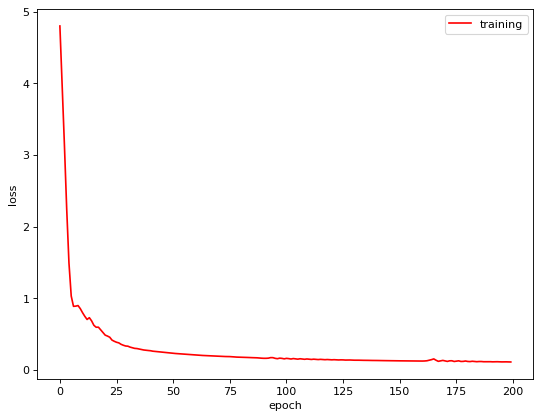

In [11]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(train_loss_arr), 'red', label = 'training')
# plt.plot(np.array(val_loss_arr), 'blue', label = 'valdation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt

In [13]:
# 测试CNN模型准确率
cnn_test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1], test_input.shape[2])
cnn_test_input = np.float32(cnn_test_input)
cnn_test_input  = torch.from_numpy(cnn_test_input).to(device)

cnn_test_label = test_label.astype(int);
cnn_test_label = torch.from_numpy(cnn_test_label).to(device)

with torch.no_grad():
    output = cnn(cnn_test_input)
softmax = torch.exp(output)
_, prediction = torch.max(softmax, axis=1)

correct_num = 0;
for i in range(prediction.shape[0]):
    if (prediction[i] == cnn_test_label[i]):
        correct_num = correct_num + 1
correct_num / prediction.shape[0]

0.9541925465838509